## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1: Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('penguins_data.csv')
data.head(10)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971
5,Gentoo,Biscoe,Yes,22,48.1,15.1,209.0,5500.0,MALE,8.45738,-26.22664
6,Gentoo,Biscoe,Yes,13,51.1,16.5,225.0,5250.0,MALE,8.20660,-26.36863
7,Gentoo,Biscoe,No,392,42.7,13.7,208.0,3950.0,FEMALE,8.14567,-26.59467
8,Adelie,Biscoe,Yes,14,39.6,20.7,191.0,3900.0,FEMALE,8.80967,-26.78958
9,Gentoo,Biscoe,Yes,735,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [3]:
data.isna().sum()

Species                 0
Island                  0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      2
Culmen Depth (mm)       2
Flipper Length (mm)     2
Body Mass (g)           2
Sex                    10
Delta 15 N (o/oo)      14
Delta 13 C (o/oo)      13
dtype: int64

Как видим, нулевые данные имеются, уберем их:

In [4]:
data.dropna(inplace=True)

In [5]:
# так же в наборе есть категориальные признаки
print(data['Sex'].value_counts())
print(data['Island'].value_counts())
print(data['Clutch Completion'].value_counts())

Sex
FEMALE    163
MALE      161
.           1
Name: count, dtype: int64
Island
Biscoe       163
Dream        119
Torgersen     43
Name: count, dtype: int64
Clutch Completion
Yes    291
No      34
Name: count, dtype: int64


Будем категореальные признаки кодировать one-hot encoding, так как для каждой переменной у нас мало возможных значений
и это не принесет нам много новых признаков, но это нам поможет избежать неявного упорядочивания признаков
Также после кодирования уберем один из столбцов наших новых категорий, чтобы не иметь проблем с мультиколлинеарностью.

In [6]:
# тут я сначала уберу запись, где в графе пол указана точка
data = data[data['Sex'] != '.']
data = pd.get_dummies(data, columns=['Island', 'Sex', 'Clutch Completion'], drop_first=True)

Целевую категориальную переменную закодируйте в ординальном порядке: Chinstrap = 0, Gentoo = 1, Adelie = 2. Можно воспользоваться [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Теперь сохраним информацию о признаках в переменную
`X`, а о целевой переменной – в переменную `y`.

In [7]:
# закодируем целевую перменную в ординальном порядке
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['Chinstrap', 'Gentoo', 'Adelie']])
data['Species'] = ordinal_encoder.fit_transform(data[['Species']])

In [8]:
data.head(10) # проверим что получилось

,Species,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Dream,Island_Torgersen,Sex_MALE,Clutch Completion_Yes
0,0.0,382,50.9,19.1,196.0,3550.0,10.02372,-24.86594,True,False,True,True
1,0.0,741,45.2,17.8,198.0,3950.0,8.88942,-24.49433,True,False,False,True
2,1.0,744,46.5,13.5,210.0,4550.0,7.99530,-25.32829,False,False,False,True
3,0.0,10,45.2,16.6,191.0,3250.0,9.62357,-24.78984,True,False,False,True
4,1.0,13,48.4,14.4,203.0,4625.0,8.16582,-26.13971,False,False,False,True
5,1.0,22,48.1,15.1,209.0,5500.0,8.45738,-26.22664,False,False,True,True
6,1.0,13,51.1,16.5,225.0,5250.0,8.20660,-26.36863,False,False,True,True
7,1.0,392,42.7,13.7,208.0,3950.0,8.14567,-26.59467,False,False,False,False
8,2.0,14,39.6,20.7,191.0,3900.0,8.80967,-26.78958,False,False,False,True
9,1.0,735,46.1,13.2,211.0,4500.0,7.99300,-25.51390,False,False,False,True


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [9]:
from sklearn.model_selection import train_test_split
np.random.seed(52)
X_train, X_test, y_train, y_test = train_test_split(data.drop('Species', axis=1), data['Species'], test_size=0.3, stratify=data['Species'])
y_train = y_train.astype('int')
y_test = y_test.astype('int')

Делаем stratify, так как без него данные могут расделиться неравномерно, особенно, если какое-то значение встречается редко. В таком сулчае оно может вообще не попасть либо в train, либо в test. Если какой-то класс не попадет в train, но будет в test, то модель вообще не научится с ним работать и выдаст плохие результаты.

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [10]:
# сначала стандартизируем данные
from sklearn.preprocessing import StandardScaler
# выделим два нужные нам признака и сразу стандартизируем их
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train[['Body Mass (g)', 'Flipper Length (mm)']])
X_test_sclaed = standard_scaler.transform(X_test[['Body Mass (g)', 'Flipper Length (mm)']])

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_list = [1, 3, 5, 10, 15, 25]
results = {}
classifiers = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_scaled, y_train)

    classifiers.append(knn)

    y_train_pred = knn.predict(X_train_scaled)
    y_test_pred = knn.predict(X_test_sclaed)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    results[k] = (train_accuracy, test_accuracy)

print('NN  Train   Test')
for k, (train_acc, test_acc) in results.items():
    print(f"{k:<2}  {train_acc:.2f}    {test_acc:.2f}")

NN  Train   Test
1   0.96    0.82
3   0.84    0.78
5   0.83    0.78
10  0.80    0.85
15  0.81    0.83
25  0.80    0.81


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [12]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [13]:
from mlxtend.plotting import plot_decision_regions

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

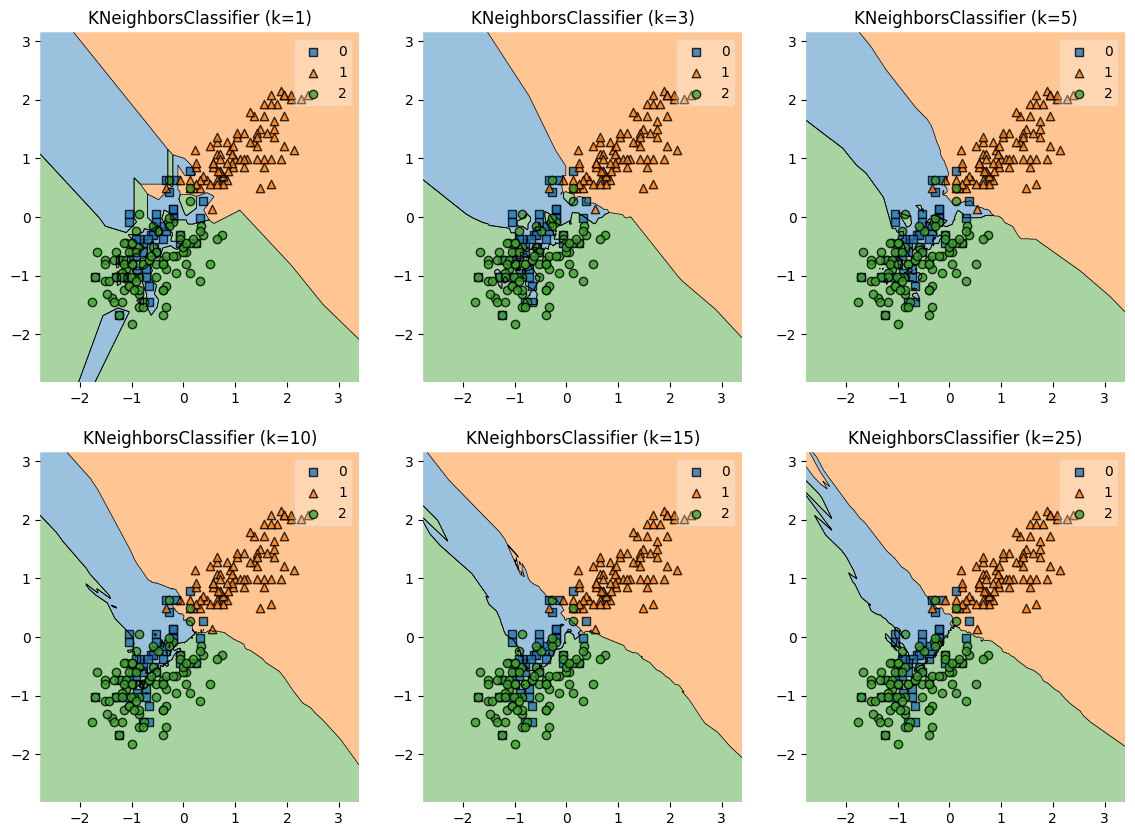

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(14,10))
for classifier, ax, k in zip(classifiers, ax.flat, k_list):
    plot_decision_regions(np.array(X_train_scaled), np.array(y_train), clf=classifier,
                          legend=1, ax=ax)
    ax.set_title('KNeighborsClassifier (k={})'.format(k))

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Доля правильных ответов при k=1 на обучающей выборке равна 0.96, а на тестовой - 0.82, что является явным признаком переобучения. Модель как бы привыкла к данным предоставленным для обучения. На графике это тоже заметно - видны сильные разрывы (резкие границы), которые указывают на то, что модель потеряла обобщающую способность и сильно адаптировалась к обущающим данным. Самые оптимальные значения при k=10. Самая высокая accuracy для test при k=10, при этом модель имеет несильно отличающуюся accuracy на train данных. При больших k доля правильных ответов на тестовой выборке уже уменьшеатеся. То же самое видно на графике - ганицы становятся более гладкими. Также на графике при k=10 видно, что происходит самое лучшее разделение.

### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

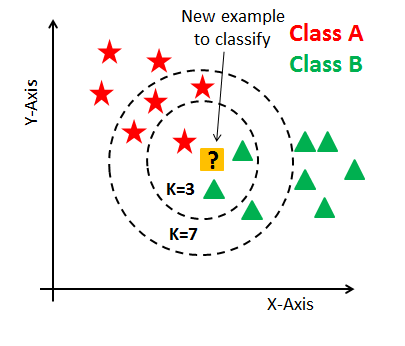

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [15]:
from collections import Counter

class KNN:
    def __init__(self, k:int):
        if k < 1:
            raise ValueError("k should be >= 1")
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train, self.y_train = np.array(X), np.array(y)
        if self.X_train.shape[0] != self.y_train.shape[0]:
            raise ValueError("Number of samples should be the same as number of training samples")

    def count_distance(self, X):
        return np.linalg.norm(X[:, np.newaxis] - self.X_train, axis=2)

    def predict(self, X):
        if self.X_train is None or self.y_train is None:
            raise Exception("Method fit should be called before predicting")
        distances = self.count_distance(np.array(X))
        nearest_neighbors = np.argsort(distances, axis=1)[:, :self.k]
        neighbor_labels = self.y_train[nearest_neighbors]
        most_common = [Counter(label).most_common(1)[0][0] for label in neighbor_labels]
        return np.array(most_common)

In [16]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [17]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

In [18]:
scaler = StandardScaler()
X_data_train = scaler.fit_transform(X_train)
X_data_test = scaler.transform(X_test)

res = {}
for k in k_list:
    knn = KNN(k)
    knn.fit(X_data_train, y_train)
    y_test_pred = knn.predict(X_data_test)
    res[k] = accuracy_score(y_test, y_test_pred)

best_k, best_accuracy = max(res.items(), key=lambda x: x[1])
print(f"Лучшее k: {best_k}, лучшая доля правильных ответов: {best_accuracy}")

Лучшее k: 3, лучшая доля правильных ответов: 1.0


In [19]:
res

{1: 0.9897959183673469,
 3: 1.0,
 5: 1.0,
 10: 0.9897959183673469,
 15: 0.9795918367346939,
 25: 0.9795918367346939}

Там при двух значениях accuracy 1.

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [20]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [21]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Как видим пропущенных значений в нашем датасете нет, но есть ненужный столбец с индексами, они у нас и так есть. Удалим этот столбец.

In [22]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.sample(3)

,carat,cut,color,clarity,depth,table,price,x,y,z
17618,1.56,Good,J,VS2,57.6,65.0,7094,7.62,7.60,4.38
33491,0.32,Ideal,F,VS2,61.9,56.0,828,4.39,4.37,2.71
194,0.70,Premium,E,SI1,61.2,57.0,2777,5.73,5.68,3.49


**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

In [23]:
data.corr(numeric_only=True)

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


Размеры (x, y, z) коррелируют с ценной (размеры больше - цена больше), что логично: чем больше размер алмаза, тем он дороже стоит. Также все размеры коррелируют между собой, чем больше x, тем больше y. Понятно, что если ширина больше, то и скорее высота тоже будет больше. А также от количества карат зависит цена на алмаз, чем он больше, тем и больше стоит. А еще количество карат коррелирует с x, y, z. При росте одного растет и другое.

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

In [24]:
data = pd.get_dummies(data, ['cut', 'color', 'clarity'], drop_first=True)
data

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,True,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,False,True,False,...,False,False,False,False,True,False,False,False,False,False
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,True,False,False,...,False,False,False,False,True,False,False,False,False,False
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,False,False,True,...,True,False,False,False,False,True,False,False,False,False


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [25]:
X = data.drop(['price'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

In [26]:
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

Стандартизация, которая преобразует все признаки так, чтобы среднее было 0, а дисперсия 1, делает коэффициенты сопоставимыми между собой, так все признаки имееют одинаковый маштаб. Это позволяет нам сравнивать вклад каждого признака в модель. При увеличении признака на 1, целевая переменная будет увеличиваться, а может быть и уменьшатся взависимости от знака соответсвующего веса, на модуль этого веса (мы перестаем работать в исходных единицах измерения). Стандартизация также помогает улучшить сходимость алгоритмов, допустим, сходимость градиентного спука и позволяет избежать различных проблем, связанных с маштабом признаков.

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'MSE на тренировачной выборке: {mse_train:.4f}, на тестовой: {mse_test:.4f}')

MSE на тренировачной выборке: 1283046.4248, на тестовой: 1263424.4057


**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [28]:
coeffs = pd.DataFrame({'features': X.columns, 'coeffs': lin_reg.coef_})
coeffs

,features,coeffs
0,carat,5312.231664
1,depth,-92.160639
2,table,-57.692146
3,x,-1101.146863
4,y,16.770684
5,z,-44.557397
6,cut_Good,163.874515
7,cut_Ideal,407.694819
8,cut_Premium,325.424569
9,cut_Very Good,299.290422


Из всех вещественных переменных выделяется carat, а также x. Их значения превышают значения остальных в десятки раз.


**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [29]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=10)
lasso.fit(X_train, y_train)

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Lasso: MSE на тренировачной выборке: {mse_train:.4f}, на тестовой: {mse_test:.4f}')

Lasso: MSE на тренировачной выборке: 1342639.5705, на тестовой: 1316350.1985


In [30]:
coeffs = pd.DataFrame({'features': X.columns, 'coeffs': lasso.coef_})
coeffs

,features,coeffs
0,carat,4806.329859
1,depth,-96.718724
2,table,-67.468373
3,x,-626.829649
4,y,-0.000000
5,z,-42.090489
6,cut_Good,44.347193
7,cut_Ideal,211.105138
8,cut_Premium,146.357800
9,cut_Very Good,136.525041


In [31]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Ridge: MSE на тренировачной выборке: {mse_train:.4f}, на тестовой: {mse_test:.4f}')

Ridge: MSE на тренировачной выборке: 1283175.7112, на тестовой: 1263494.3319


In [32]:
coeffs = pd.DataFrame({'features': X.columns, 'coeffs': ridge.coef_})
coeffs

,features,coeffs
0,carat,5272.878914
1,depth,-90.275900
2,table,-57.846440
3,x,-1057.680197
4,y,14.195459
5,z,-48.263878
6,cut_Good,164.710738
7,cut_Ideal,409.270141
8,cut_Premium,326.780962
9,cut_Very Good,301.015283


Видно, что коэффициенты не так сильно уменьшились, следовательно, большой проблемы с мультиколлинеарностью не было.

**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 – обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [33]:
alphas = [0.1, 1, 10, 100, 200]
lasso_norm = []
ridge_norm = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train)
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    lasso_norm.append(np.linalg.norm(lasso.coef_))
    ridge_norm.append(np.linalg.norm(ridge.coef_))

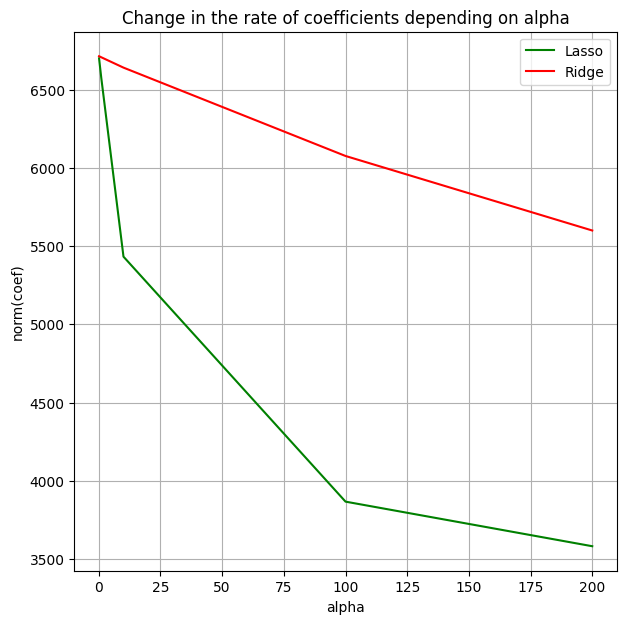

In [34]:
plt.figure(figsize=(7, 7))
plt.plot(alphas, lasso_norm, label='Lasso', color='green')
plt.plot(alphas, ridge_norm, label='Ridge', color='red')
plt.grid(True)
plt.title('Change in the rate of coefficients depending on alpha')
plt.xlabel('alpha')
plt.ylabel('norm(coef)')
plt.legend()
plt.show()

Видно, что Lasso значительно сильнее снижает норму коэффициентов. Lasso зануляет все больше коэффициентов при увеличении alpha, так как L-1 регуляризация добавляет штраф, пропорциональный абсолютным значениям коэффициентов моделей. Это и приводит к обнулению коэффициентов у незначимых признаков.

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [35]:
from sklearn.linear_model import LassoCV
alphas_for_lasso_cv = np.linspace(0.01, 50, 100)
lasso_cv = LassoCV(cv=5, alphas=alphas_for_lasso_cv, max_iter=10000)
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 5.14949495e-01, 1.01989899e+00, 1.52484848e+00,
       2.02979798e+00, 2.53474747e+00, 3.03969697e+00, 3.54464646e+00,
       4.04959596e+00, 4.55454545e+00, 5.05949495e+00, 5.56444444e+00,
       6.06939394e+00, 6.57434343e+00, 7.07929293e+00, 7.58424242e+00,
       8.08919192e+00, 8.59414141e+00, 9.09909091e+00, 9.60404040e+00,
       1.01089899e+01, 1.06139394e+0...
       3.83861616e+01, 3.88911111e+01, 3.93960606e+01, 3.99010101e+01,
       4.04059596e+01, 4.09109091e+01, 4.14158586e+01, 4.19208081e+01,
       4.24257576e+01, 4.29307071e+01, 4.34356566e+01, 4.39406061e+01,
       4.44455556e+01, 4.49505051e+01, 4.54554545e+01, 4.59604040e+01,
       4.64653535e+01, 4.69703030e+01, 4.74752525e+01, 4.79802020e+01,
       4.84851515e+01, 4.89901010e+01, 4.94950505e+01, 5.00000000e+01]),
        cv=5, max_iter=10000)

In [36]:
best_alpha = lasso_cv.alphas_[np.argmin(np.mean(lasso_cv.mse_path_, axis=1))]
print(f'Оптимальное значение aplha: {best_alpha}')

Оптимальное значение aplha: 1.5248484848484847


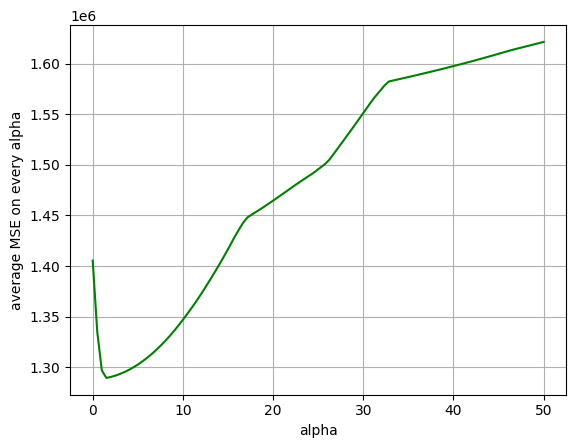

In [37]:
# просто посмотрим на график, зависимости средней mse от alpha
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), color='green')
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('average MSE on every alpha')
plt.show()

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [38]:
lasso_final = Lasso(alpha=best_alpha)
lasso_final.fit(X_train, y_train)
coeffs = pd.DataFrame({'features': X.columns, 'coeffs': lasso_final.coef_})
coeffs

,features,coeffs
0,carat,5235.283714
1,depth,-93.231685
2,table,-59.265608
3,x,-1017.333497
4,y,-0.000000
5,z,-42.048068
6,cut_Good,146.001035
7,cut_Ideal,378.239181
8,cut_Premium,298.420144
9,cut_Very Good,275.027408


Самым информативным оказался carat. Это вес брильянта, если он больше, то и стоить этот брильянт будет больше. Также clarity (чистота алмаза) тоже влияет сильно: у нее довольно большие веса. Cut не влияет на цену так сильно. Но видно чем он лучше тем больше вносит в цену. X сильно влияет на цену, в то время как y и z имеют очень маленькие веса, возможно потому что все 3 признака между собой зависимы. Depth и table почти не имеют влияния на цену, тоже геометрические параметры, которые зависят от x, y, z, но не линейно (поэтому в таблице корреляций ничего не видим). Так же чем "хуже" (J-"самый плохой", D-"самый лучший") цвет алмаза тем меньше будет цена, но опять же влияние этого признака не такое сильно как другие.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [39]:
mse_lasso_final = mean_squared_error(y_test, lasso_final.predict(X_test))
mse_lin_reg = mean_squared_error(y_test, lin_reg.predict(X_test))
print(f'Lasso MSE: {mse_lasso_final}, LinReg MSE: {mse_lin_reg}')

Lasso MSE: 1263882.8666299963, LinReg MSE: 1263424.405693591


MSE почти одинкаковая для обеих моделей. Это может быть свзяано с отсутствием мультиколлинеарности в данных и/или переобучения модели. Поэтому можно использовать любую модель в данном случае.